In [1]:
import pandas as pd
import numpy as np
import random as rnd
from termcolor import colored
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

bold_start = '\033[1m'
underline_start = '\033[4m'
bu_end = '\033[0m'


In [2]:
train_df = pd.read_csv('death_prediction_synthetic.csv')

In [3]:
def high_correlation_values(cor):
    sorted_cor = cor.unstack()
    sorted_cor = sorted_cor.sort_values()
    sorted_cor = sorted_cor.loc[((sorted_cor > 0.5) | (sorted_cor < -0.5)) & (sorted_cor != 1)]
    print(sorted_cor[::2])

In [4]:
def plot_correlation(method='pearson', cor_return = False):
    cor = train_df.corr(method=method)
    plt.figure(figsize=(28,28))
    plt.title("The method used: " + method[0].upper() + method[1:], fontsize=25)
    sns.heatmap(np.abs(round(cor, 3)), annot=True, cmap='Greys')
    plt.show() 
    if cor_return:
        return cor

In [5]:
def remove_outliers():
    list_of_counts = []
    clean_df = train_df.copy()
    for col in clean_df:
        if pd.api.types.is_numeric_dtype(clean_df[col]) and clean_df[col].dtype != 'int64': # is numeric 
            Q1 = np.percentile(clean_df[col],25)
            Q3 = np.percentile(clean_df[col],75)
            IQR = Q3 - Q1
            IQR_range = IQR * 1.5
            clean_df.loc[ (clean_df[col] < Q1 - IQR_range) | (clean_df[col] > Q3 + IQR_range), [col]] = np.nan
            count = clean_df[col].isna().sum()
            list_of_counts.append(count)
            
    return clean_df, list_of_counts

In [6]:
def remove_corrupt_rows(df):
    df2_clean = pd.DataFrame()
    df2_clean = df.dropna(axis=0,how = 'any')
    return df2_clean

Reading the data and understading the types

In [7]:
des_df = {  'attName':[],
            'count':[],
            'mean':[],
            'std':[], 
            'min':[], 
            '25%':[], 
            '50%':[], 
            '75%':[], 
            'max':[]
            }
for att in train_df.columns:
    description = train_df[att].describe(include='all')
    des_df['attName'].append(att)
    for key in list(des_df.keys())[1:]:
        try:
            des_df[key].append(description[key])
        except:
            des_df[key].append(np.NaN)
des_df = pd.DataFrame(data=des_df)
des_df.to_csv("description.csv")
des_df.head()

attName    count       mean       std   min   25%   50%   75%   max
0             age  12438.0  43.501126  4.802035  30.0  41.0  45.0  48.0  49.0
1             sex  12438.0   1.468805  0.499046   1.0   1.0   1.0   2.0   2.0
2  marital_status  12438.0        NaN       NaN   NaN   NaN   NaN   NaN   NaN
3             ses  12438.0   1.677279  0.763641   1.0   1.0   1.0   2.0   3.0
4    residence_cd  12438.0   1.062631  0.242307   1.0   1.0   1.0   1.0   2.0

In [8]:
numberOfPeople = train_df.shape[0]
totalDeath = train_df["dead_5y"].sum()

The following will justify why we choose our approach. In summary, according to the Central Bureau of Statistics the data we are dealing with have a large rate of sick (causes of death) people. 

We decided to use unsupervised learning to classify the risk groups. Unsupervised learning allows us to automatically identify patterns in the data and classify them into risk groups. This is a more efficient way of dealing with data that has a large rate of sick people, as it requires less manual intervention and will provide more accurate results.

In [9]:
old_death_population = {
    2018: (1770, 2229702),
    2017: (1780, 2191646),
    2016: (1798, 2150096),
    2015: (1697, 2110721),
    2014: (1733, 2070562),
    2013: (1694, 2030785),
    2012: (1699, 1990188),
    2011: (1704, 1952624),
    }
print(f'{"Year":<8s} | {"Death":<10s} | {"Population":<10s} | {"DeathRate":<10s}')
for year in old_death_population.keys():
    death_rate_s = round((old_death_population[year][0]/old_death_population[year][1])*100, 4)
    print(f'{year:<8} | {old_death_population[year][0]:<10} | {old_death_population[year][1]:<10} | {death_rate_s:<10}%')

print(bold_start + underline_start+  f'{"Data":<8} | {totalDeath:<10} | {numberOfPeople:<10} | {str(round(totalDeath/numberOfPeople*100, 4)):<10}%' + bu_end)


Year     | Death      | Population | DeathRate 
2018     | 1770       | 2229702    | 0.0794    %
2017     | 1780       | 2191646    | 0.0812    %
2016     | 1798       | 2150096    | 0.0836    %
2015     | 1697       | 2110721    | 0.0804    %
2014     | 1733       | 2070562    | 0.0837    %
2013     | 1694       | 2030785    | 0.0834    %
2012     | 1699       | 1990188    | 0.0854    %
2011     | 1704       | 1952624    | 0.0873    %
Data     | 197        | 12438      | 1.5839    %


The following section will be the data preparation, we'll preform data cleaning, transformation, selection etc. It's like putting together a puzzle; gathering the pieces, arranging them in the right order and ensuring no pieces are missing.

First we'll find the attributes contains NULL values.

In [10]:
nullContainAtt = dict()
print(f'{"Attribute":<14} {"Null Values":}  {"Null Rate":}')
for attName in train_df.columns:
    train_df[train_df == "NA"] = np.nan
    train_df[train_df == "NaN"] = np.nan
    numOfNulls = train_df[attName].isna().sum()
    if numOfNulls > 0:
        nullContainAtt[attName] = [numOfNulls, numOfNulls/numberOfPeople]
        print(f'{bold_start}{attName:<14} {numOfNulls:<10}{bu_end} {round(numOfNulls/numberOfPeople,2)*100:>10}')
train_df[train_df == "NA"] = np.nan
train_df[train_df == "NaN"] = np.nan

Attribute      Null Values  Null Rate
albumin        1463             12.0
alb24h         8918             72.0
ACR            1212             10.0
gravity_u      2530             20.0
nitrites_u     2520             20.0
leuko_u        2507             20.0
proteinuria    2506             20.0


In [11]:
def plot_null_features():
  d = train_df[['ACR','gravity_u','nitrites_u','leuko_u','proteinuria']]
  d.describe(include='all'), d.median()
  fig, axes = plt.subplots(nrows=5, ncols=2)
  fig.set_figheight(12)
  fig.set_figwidth(8)
  j = 0
  for col in d.columns:
    d.hist(column=col, bins=20, grid=False, ax=axes[j, 0])
    d[col].plot.kde(ax=axes[j, 1])
    title = col
    fontSize = 10
    colour = 'black'
    axes[j, 0].set_title(title, fontsize=fontSize, color=colour)
    axes[j, 1].set_title(title, fontsize=fontSize, color=colour)
    j+=1
  print(pd.Series({col:d[col].unique() for col in d}))
  print(d.describe(include='all'))

ACR            [6.0, 3.87, 6.35, 5.0, 0.48, 30.0, 4.16, 3.14,...
gravity_u      [1.025, 1.021, 1.03, 1.017, 1.028, 1.02, nan, ...
nitrites_u                                  [0.0, nan, 1.0, 2.0]
leuko_u        [0.0, 1.0, nan, 75.0, 100.0, 25.0, 250.0, 500....
proteinuria                                      [0.0, nan, 1.0]
dtype: object
                ACR    gravity_u   nitrites_u      leuko_u  proteinuria
count  11226.000000  9908.000000  9918.000000  9931.000000  9932.000000
mean      38.829212     1.022250     0.037709    40.851576     0.050745
std      117.962082     0.008226     0.202310   120.788718     0.219488
min        0.000000     1.000000     0.000000     0.000000     0.000000
25%        3.870000     1.016000     0.000000     0.000000     0.000000
50%        7.000000     1.021000     0.000000     0.000000     0.000000
75%       21.000000     1.028000     0.000000     0.000000     0.000000
max     1494.570000     1.050000     2.000000   500.000000     1.000000


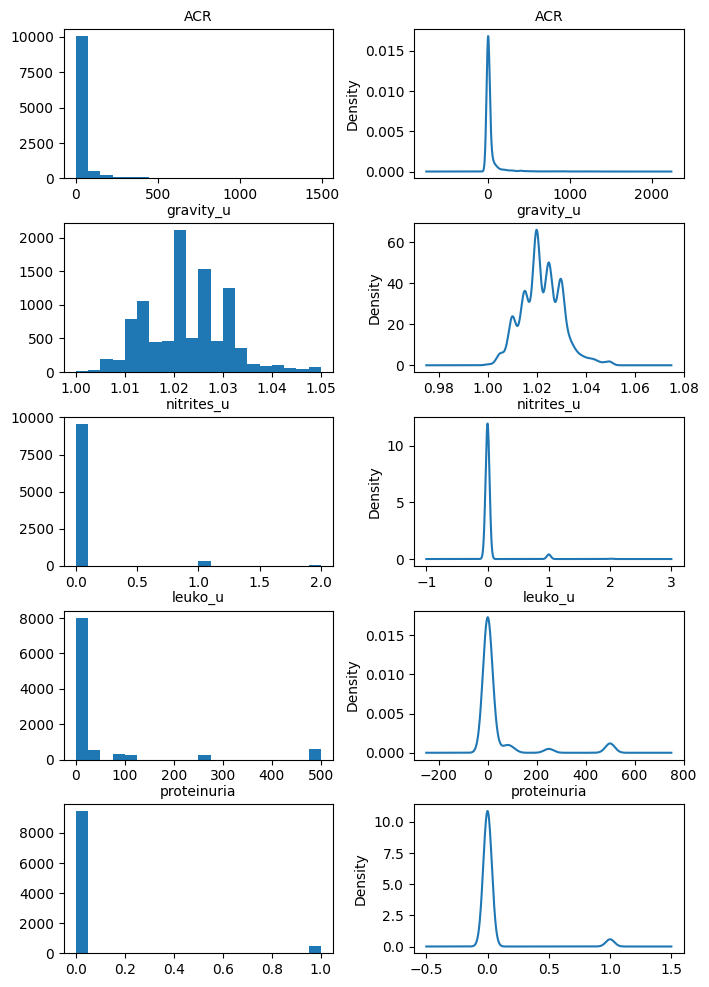

In [12]:
plot_null_features()

In [13]:
random_vals = pd.Series(np.abs(np.random.normal(size=1212)))
random_around_median = list(random_vals * train_df['ACR'].median())
acr_replacment = []
for i in train_df['ACR']:
    if math.isnan(i):
        acr_replacment.append(random_around_median.pop(0))
    else:
        acr_replacment.append(i)

train_df['ACR'] = pd.Series(acr_replacment)


In [14]:
train_df['gravity_u'] = train_df['gravity_u'].fillna(method='ffill')

The description file helps to understand that cancer have no effect so we'll remove this attribute
albumin have 70%+ missing values
nitrites and protein in the urine is not a large death risk

In [15]:
train_df = train_df.drop(["cancer", "alb24h", "nitrites_u", "proteinuria", "leuko_u"], axis=1)
train_df.head()

age  sex marital_status  ses  residence_cd residence  weigh  heigh    BMI  \
0   49    2              U    1             1     urban   84.0  160.0  32.79   
1   46    2              M    1             1     urban   67.0  152.0  29.38   
2   46    2              U    1             1     urban   62.4  148.0  28.31   
3   45    1              U    2             1     urban   73.9  166.0  26.85   
4   49    2              U    1             1     urban   53.0  161.0  20.45   

   bp_sys  ...  Charlson framingham_cvd  antidiabetics ERD  CVD  HTN  \
0     116  ...         1        0.12908              1   0    0    1   
1     113  ...         1        0.08500              1   0    0    0   
2     133  ...         1        0.10715              1   0    0    1   
3     100  ...         1        0.10110              1   0    0    0   
4     110  ...         1        0.03950              1   0    0    0   

   cardiovascular_meds  statines  immigrant  dead_5y  
0                    1         1          0        0  
1                    1         1          0        0  
2                    1         1          0        0  
3                    0         1          0        0  
4                    0         1          0        0  

[5 rows x 40 columns]

In [16]:
# Transform the sex feature to binary
train_df['sex'] = train_df['sex'] - 1
train_df['sex'].value_counts()

0    6607
1    5831
Name: sex, dtype: int64

In [17]:
train_df.select_dtypes(exclude=['int64', 'float64'])

marital_status residence   bp_cat  smoking_status
0                  U     urban   Normal      non_smoker
1                  M     urban   Normal      non_smoker
2                  U     urban  Pre-HTN      non_smoker
3                  U     urban   Normal  current_smoker
4                  U     urban   Normal      non_smoker
...              ...       ...      ...             ...
12433              U     urban  Pre-HTN      non_smoker
12434              M     urban   Normal      non_smoker
12435              U     urban   Normal  current_smoker
12436              M     urban   Normal      non_smoker
12437              M     urban   Normal  current_smoker

[12438 rows x 4 columns]

In [18]:
train_df['residence'].value_counts(), train_df['residence_cd'].value_counts()

(urban    11659
 rural      779
 Name: residence, dtype: int64,
 1    11659
 2      779
 Name: residence_cd, dtype: int64)

We can drop the string residence column since the residence and residence_cd columns both contain the same values.

In [19]:
train_df = train_df.drop(["residence"], axis=1)

נשנה את סטטוס הנישואים לבינארי, נשוי/ה (1) או לא (0), בהתאם למה שעשינו לפני

In [20]:
train_df['marital_status'] = train_df['marital_status'].map({"U" : 0, "M": 1})
train_df['smoking_status'].value_counts(), train_df['smoking'].value_counts()

(non_smoker        7806
 current_smoker    3287
 past_smoker       1345
 Name: smoking_status, dtype: int64,
 1    7806
 3    3287
 2    1345
 Name: smoking, dtype: int64)

In [21]:
# Its quite easy to see that the smoking and smoking status are the same, we'll drop the smoking status since it's string
train_df = train_df.drop(columns='smoking_status', axis=1)

נבדוק קורלציה בין ביפי_קאט לעמודות השונות

In [22]:
train_df['bp_cat'] = train_df['bp_cat'].map({"Normal": 0, "Pre-HTN": 1, "HTN-G1": 2, "HTN-G2": 3, "HTN-G3": 4}).astype(int)

In [23]:
train_df.loc[(train_df['bp_cat'] == 1)]

age  sex  marital_status  ses  residence_cd   weigh  heigh    BMI  \
2       46    1               0    1             1   62.40  148.0  28.31   
9       44    1               1    1             1   72.00  164.0  26.77   
10      33    0               1    1             1  112.00  185.0  32.72   
17      49    1               1    2             1   78.00  157.5  31.24   
19      45    0               0    2             1   83.00  169.0  29.06   
...    ...  ...             ...  ...           ...     ...    ...    ...   
12417   49    0               1    1             1   78.00  175.0  25.60   
12425   44    1               1    2             1   98.85  167.0  35.14   
12429   48    1               0    2             1   80.00  161.0  30.86   
12432   48    0               1    1             2   94.00  170.0  32.53   
12433   46    0               0    2             1   54.00  168.0  18.78   

       bp_sys  bp_dias  ...  Charlson  framingham_cvd  antidiabetics  ERD  \
2         133       87  ...         1         0.10715              1    0   
9         137       76  ...         2         0.09586              1    0   
10        130       80  ...         1         0.03946              1    0   
17        130       89  ...         1         0.11276              1    0   
19        117       86  ...         1         0.08349              1    0   
...       ...      ...  ...       ...             ...            ...  ...   
12417     137       86  ...         3         0.37036              1    0   
12425     130       80  ...         1         0.11030              1    0   
12429     130       75  ...         3         0.16726              1    0   
12432     126       85  ...         1         0.41173              1    0   
12433     130       80  ...         1         0.11655              1    0   

       CVD  HTN  cardiovascular_meds  statines  immigrant  dead_5y  
2        0    1                    1         1          0        0  
9        0    0                    0         0          0        0  
10       0    1                    1         1          0        0  
17       0    1                    1         1          1        0  
19       0    0                    1         0          1        0  
...    ...  ...                  ...       ...        ...      ...  
12417    0    1                    1         1          1        0  
12425    0    0                    0         1          0        0  
12429    0    0                    0         1          1        0  
12432    0    1                    1         1          0        0  
12433    0    0                    1         0          0        0  

[2809 rows x 38 columns]

In [24]:
max(train_df['bp_sys']), max(train_df['bp_dias'])

(200, 135)

The first table shows the countnious features correlation, we'll deal the categorical features later.

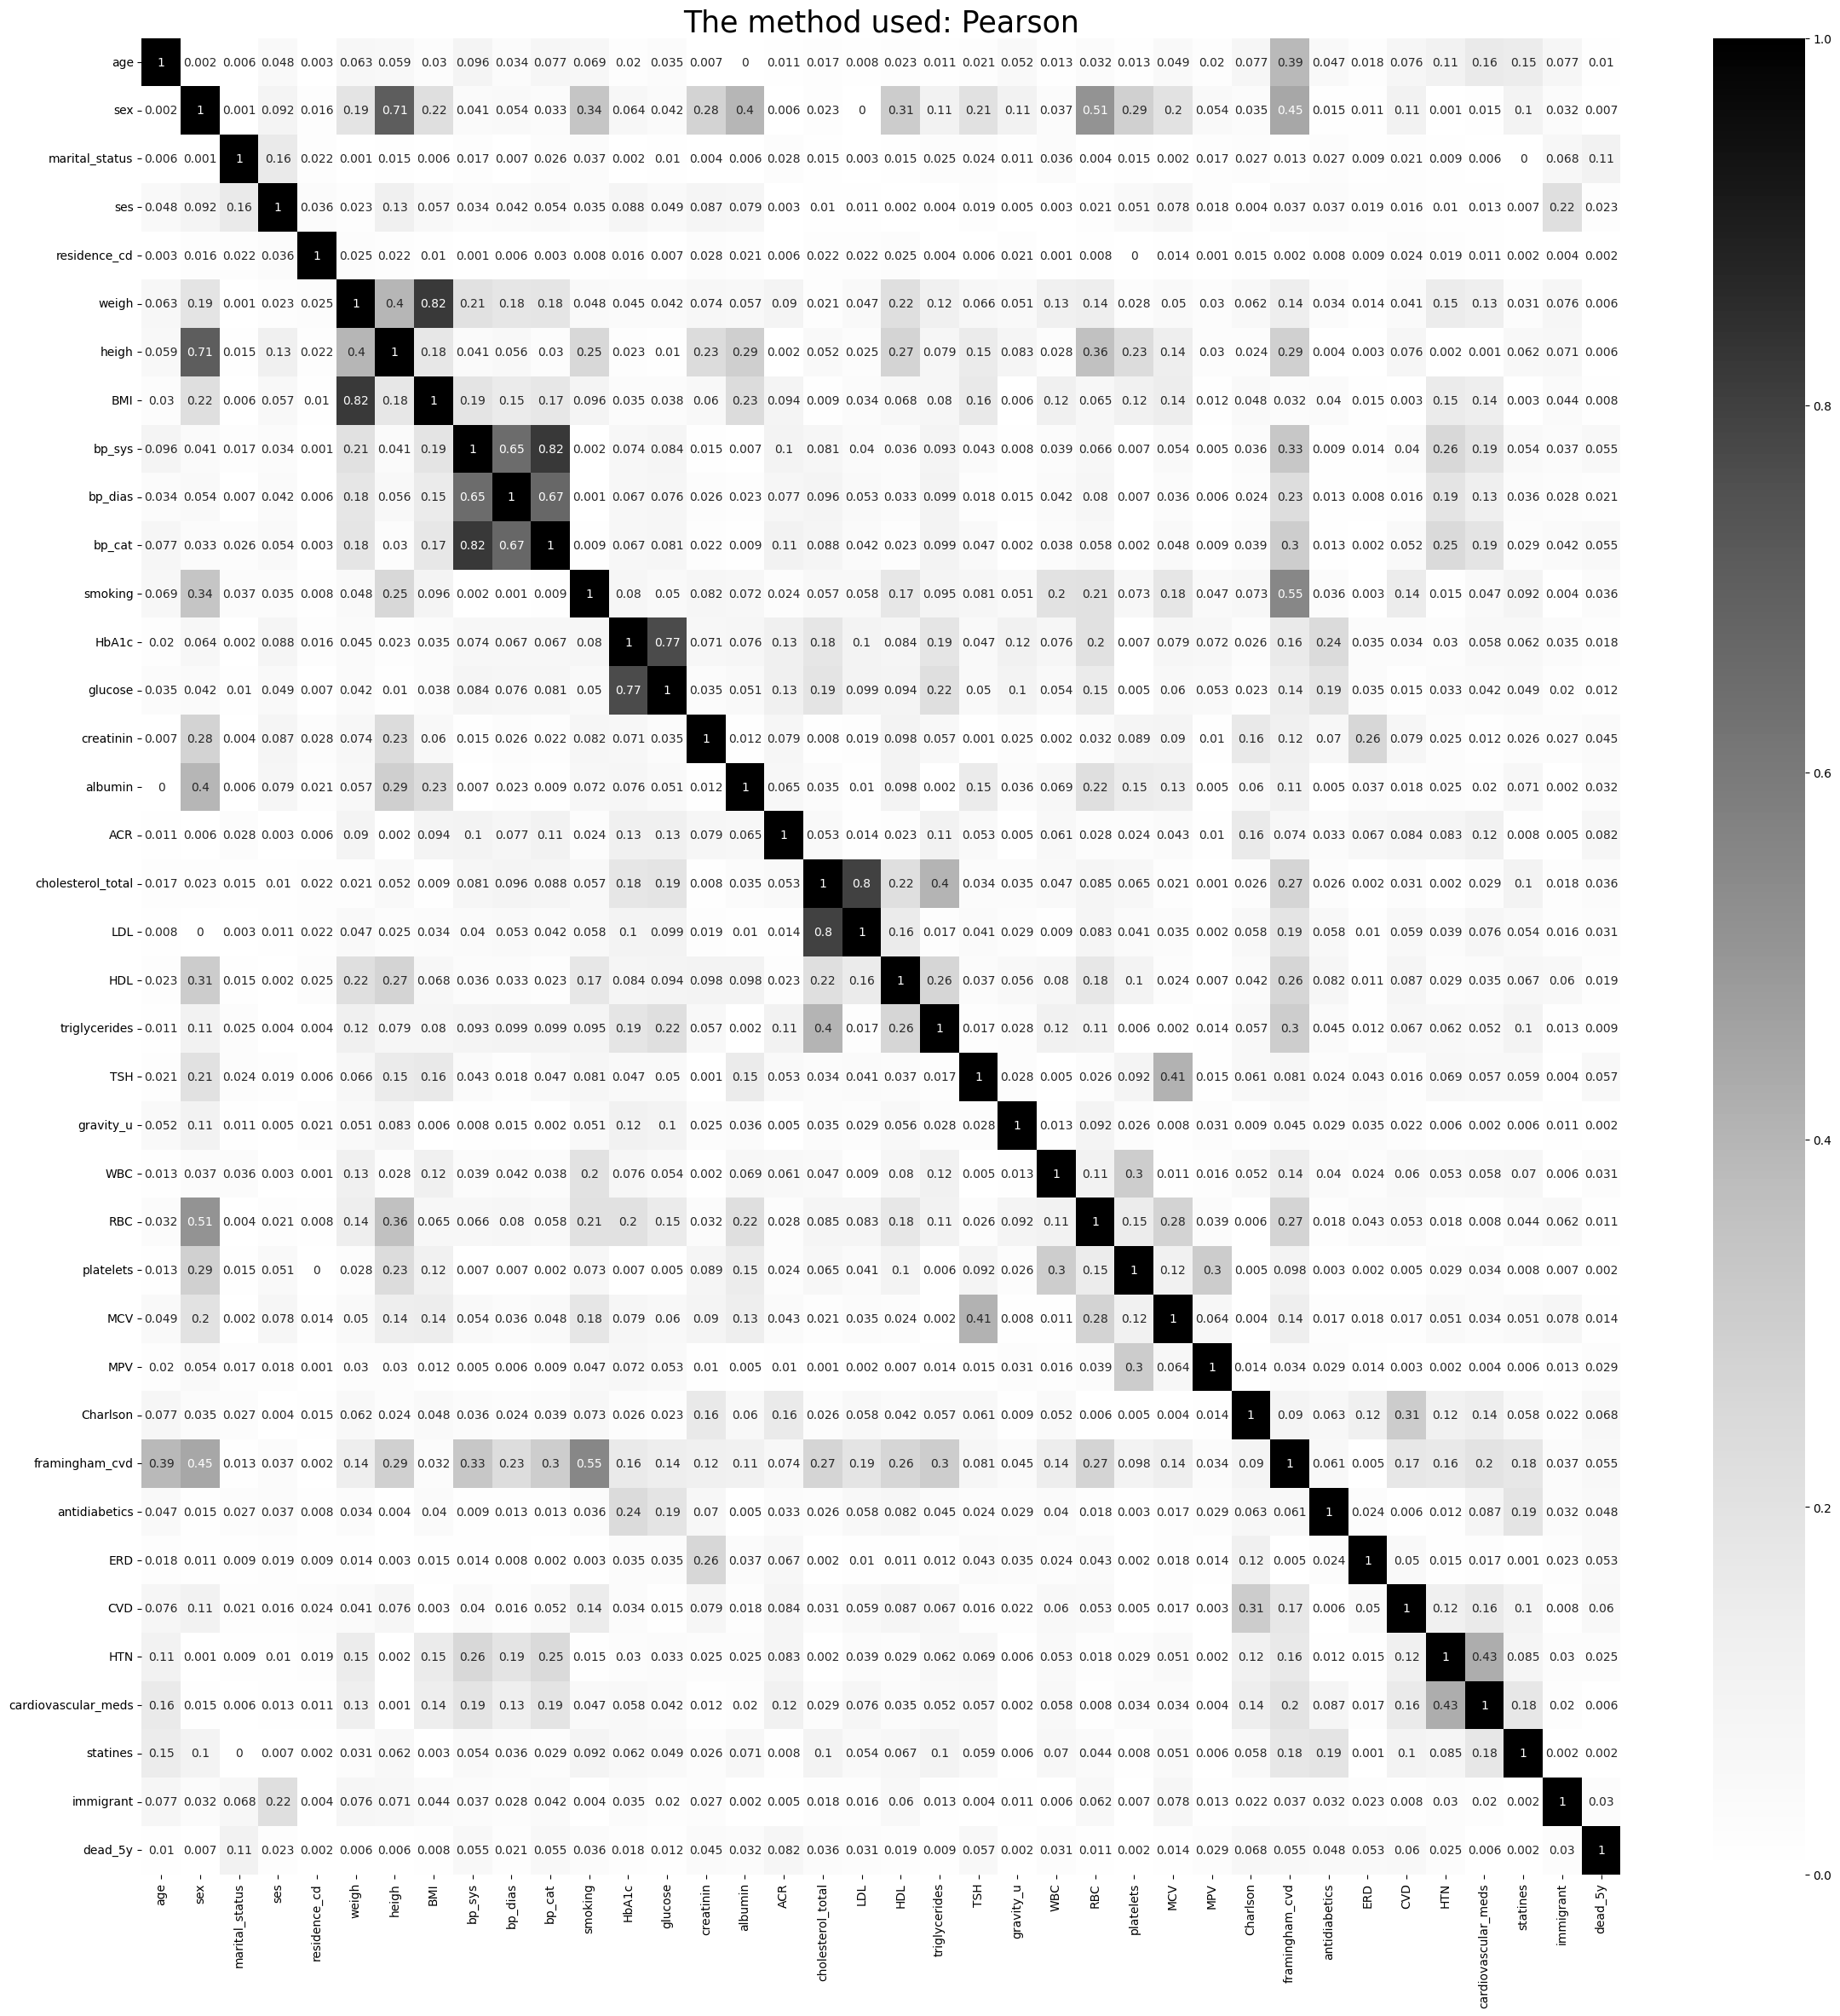

In [25]:
plot_correlation()

#In the following part we'll deal with feature selection in order to avoid multicollinearity 

High correlation between bp_sys and bp_dias to bp cat so we think that bp_cat maps those two features well

In [26]:
train_df.to_csv('new_dataset.csv')

In [27]:

bp_pca = train_df[['bp_sys', 'bp_dias', 'bp_cat']]
pca = PCA(n_components=2)
pca.fit(bp_pca)
data_pca = pca.transform(bp_pca)
train_df['PC1'] = data_pca[:, 0]
train_df['PC2'] = data_pca[:, 1]

המטרה בשילוב הפיצרים היא בשיפור הקורלציות והורדת המימדים כך שננסה לבטא את קאט באמצעות העמודות האחרות, אכן יש שיפור בקורלציות (להוסיף באיזה שיפור)

In [28]:
train_df.to_csv('new_dataset.csv')
# train_df = train_df.drop(['bp_sys', 'bp_dias', 'bp_cat'], axis=1)

In [29]:
train_df['albumin'].describe() # we know that mean is not affected by noise

count    10975.000000
mean         4.327445
std          0.329294
min          2.500000
25%          4.100000
50%          4.300000
75%          4.530000
max          5.700000
Name: albumin, dtype: float64

In [30]:
train_df['albumin'] = train_df['albumin'].fillna(train_df['albumin'].mean()) # מלאים את החציוני באוכלוסיה כדי לשמור על העמודה ולהשתמש בה

לא סומכים על מדד הביאמי שניתן לנו, ניתן לראות שבחישוב מקומי הגדלנו את הקורלציות.

In [31]:
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')
train_df['BMI'] = train_df['weigh'] / (train_df['heigh'] ** 2)
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')

BMI <-> weigh 0.817, BMI <-> heigh -0.1784
BMI <-> weigh 0.8226, BMI <-> heigh -0.1803


נזרוק את עמודות המשקל והגובה כדי להוריד מימדים ונשתמש בביאמי

In [32]:
# train_df = train_df.drop(['weigh', 'heigh'], axis=1)

In [33]:
train_df.to_csv('new_dataset.csv')

(<AxesSubplot: xlabel='LDL', ylabel='Density'>,
 <AxesSubplot: xlabel='cholesterol_total', ylabel='Density'>)

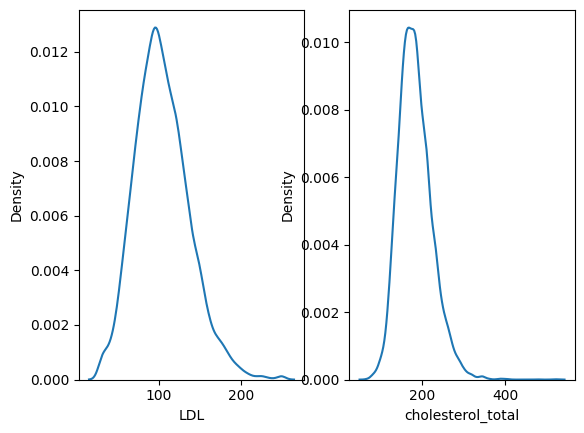

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
sns.kdeplot(train_df['LDL'], ax=ax), sns.kdeplot(train_df['cholesterol_total'], ax=ax1)

In [35]:
cor = train_df.corr()
cor['cholesterol_total'].loc[(np.abs(cor['cholesterol_total']) > 0.5) & (cor['cholesterol_total'] != 1)]

LDL    0.795632
Name: cholesterol_total, dtype: float64

In [36]:
# We diceded to drop the cholesterol_total feature because it's high correlation
# train_df = train_df.drop(columns='cholesterol_total', axis=1)

In [37]:
# Sex and smoking are categorical feature so we'll test it again using spearman correlation
print(train_df['HbA1c'].describe(), train_df['glucose'].describe())

count    12438.000000
mean         7.623666
std          1.867250
min          4.000000
25%          6.300000
50%          7.100000
75%          8.500000
max         16.800000
Name: HbA1c, dtype: float64 count    12438.000000
mean       153.757276
std         64.724782
min         40.000000
25%        110.000000
50%        134.000000
75%        177.000000
max        883.000000
Name: glucose, dtype: float64


In [38]:
train_df['mult_glu_HbA'] = train_df['HbA1c'] * train_df['glucose']

In [39]:
# So the multiplication of glucose and HbA1c works well, we can drop those features and stay with the new feature
# train_df = train_df.drop(["glucose", "HbA1c"], axis=1)

In [40]:
train_df['creatinin'].describe()

count    12438.000000
mean         0.751235
std          0.428875
min          0.110000
25%          0.600000
50%          0.710000
75%          0.840000
max         11.150000
Name: creatinin, dtype: float64

In [41]:
sex_pca = TSNE(2)#.fit(train_df[['sex', 'RBC', 'creatinin']])
p =  sex_pca.fit_transform(train_df[['sex', 'RBC', 'creatinin']])
train_df['new_rbc'] = p[:, 0]
train_df['new_rbc2'] = p[:, 1]
# train_df = train_df.drop(columns=['sex', 'RBC', 'creatinin'])

we'll drop the smoking feature, the framingham cvd rate contributes more to know who will die.

In [42]:
train_df.to_csv('new_dataset.csv')

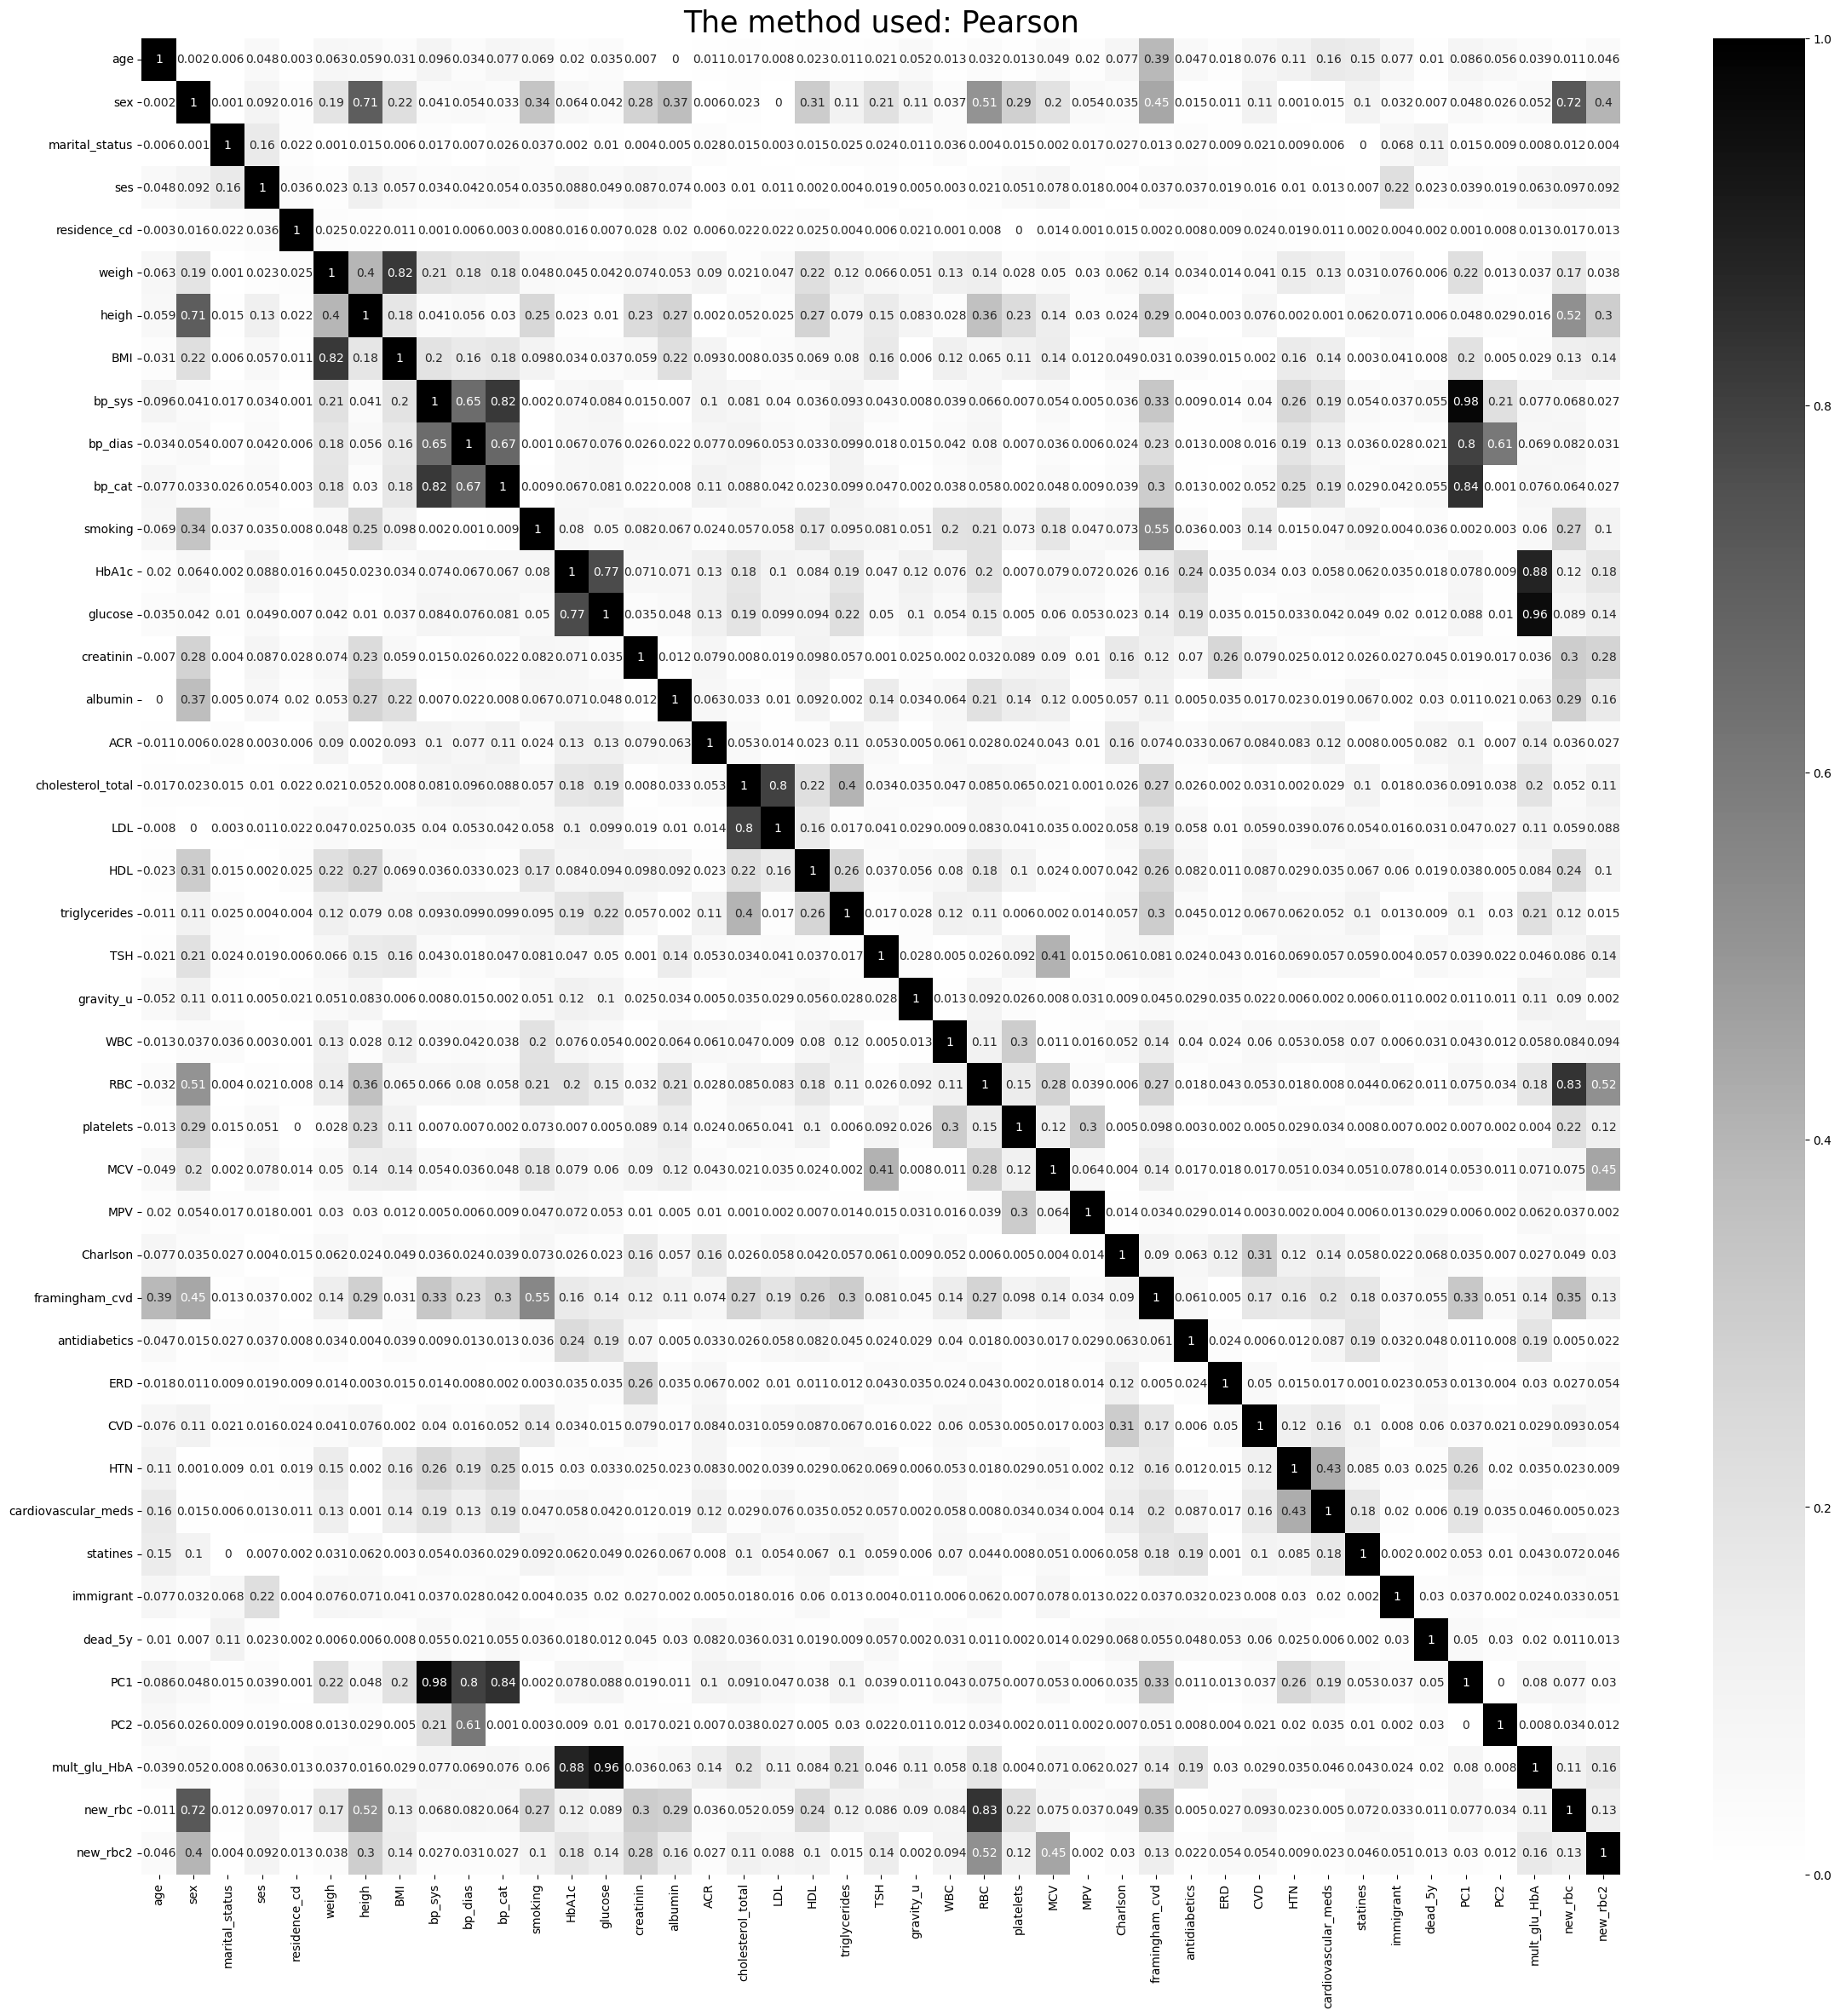

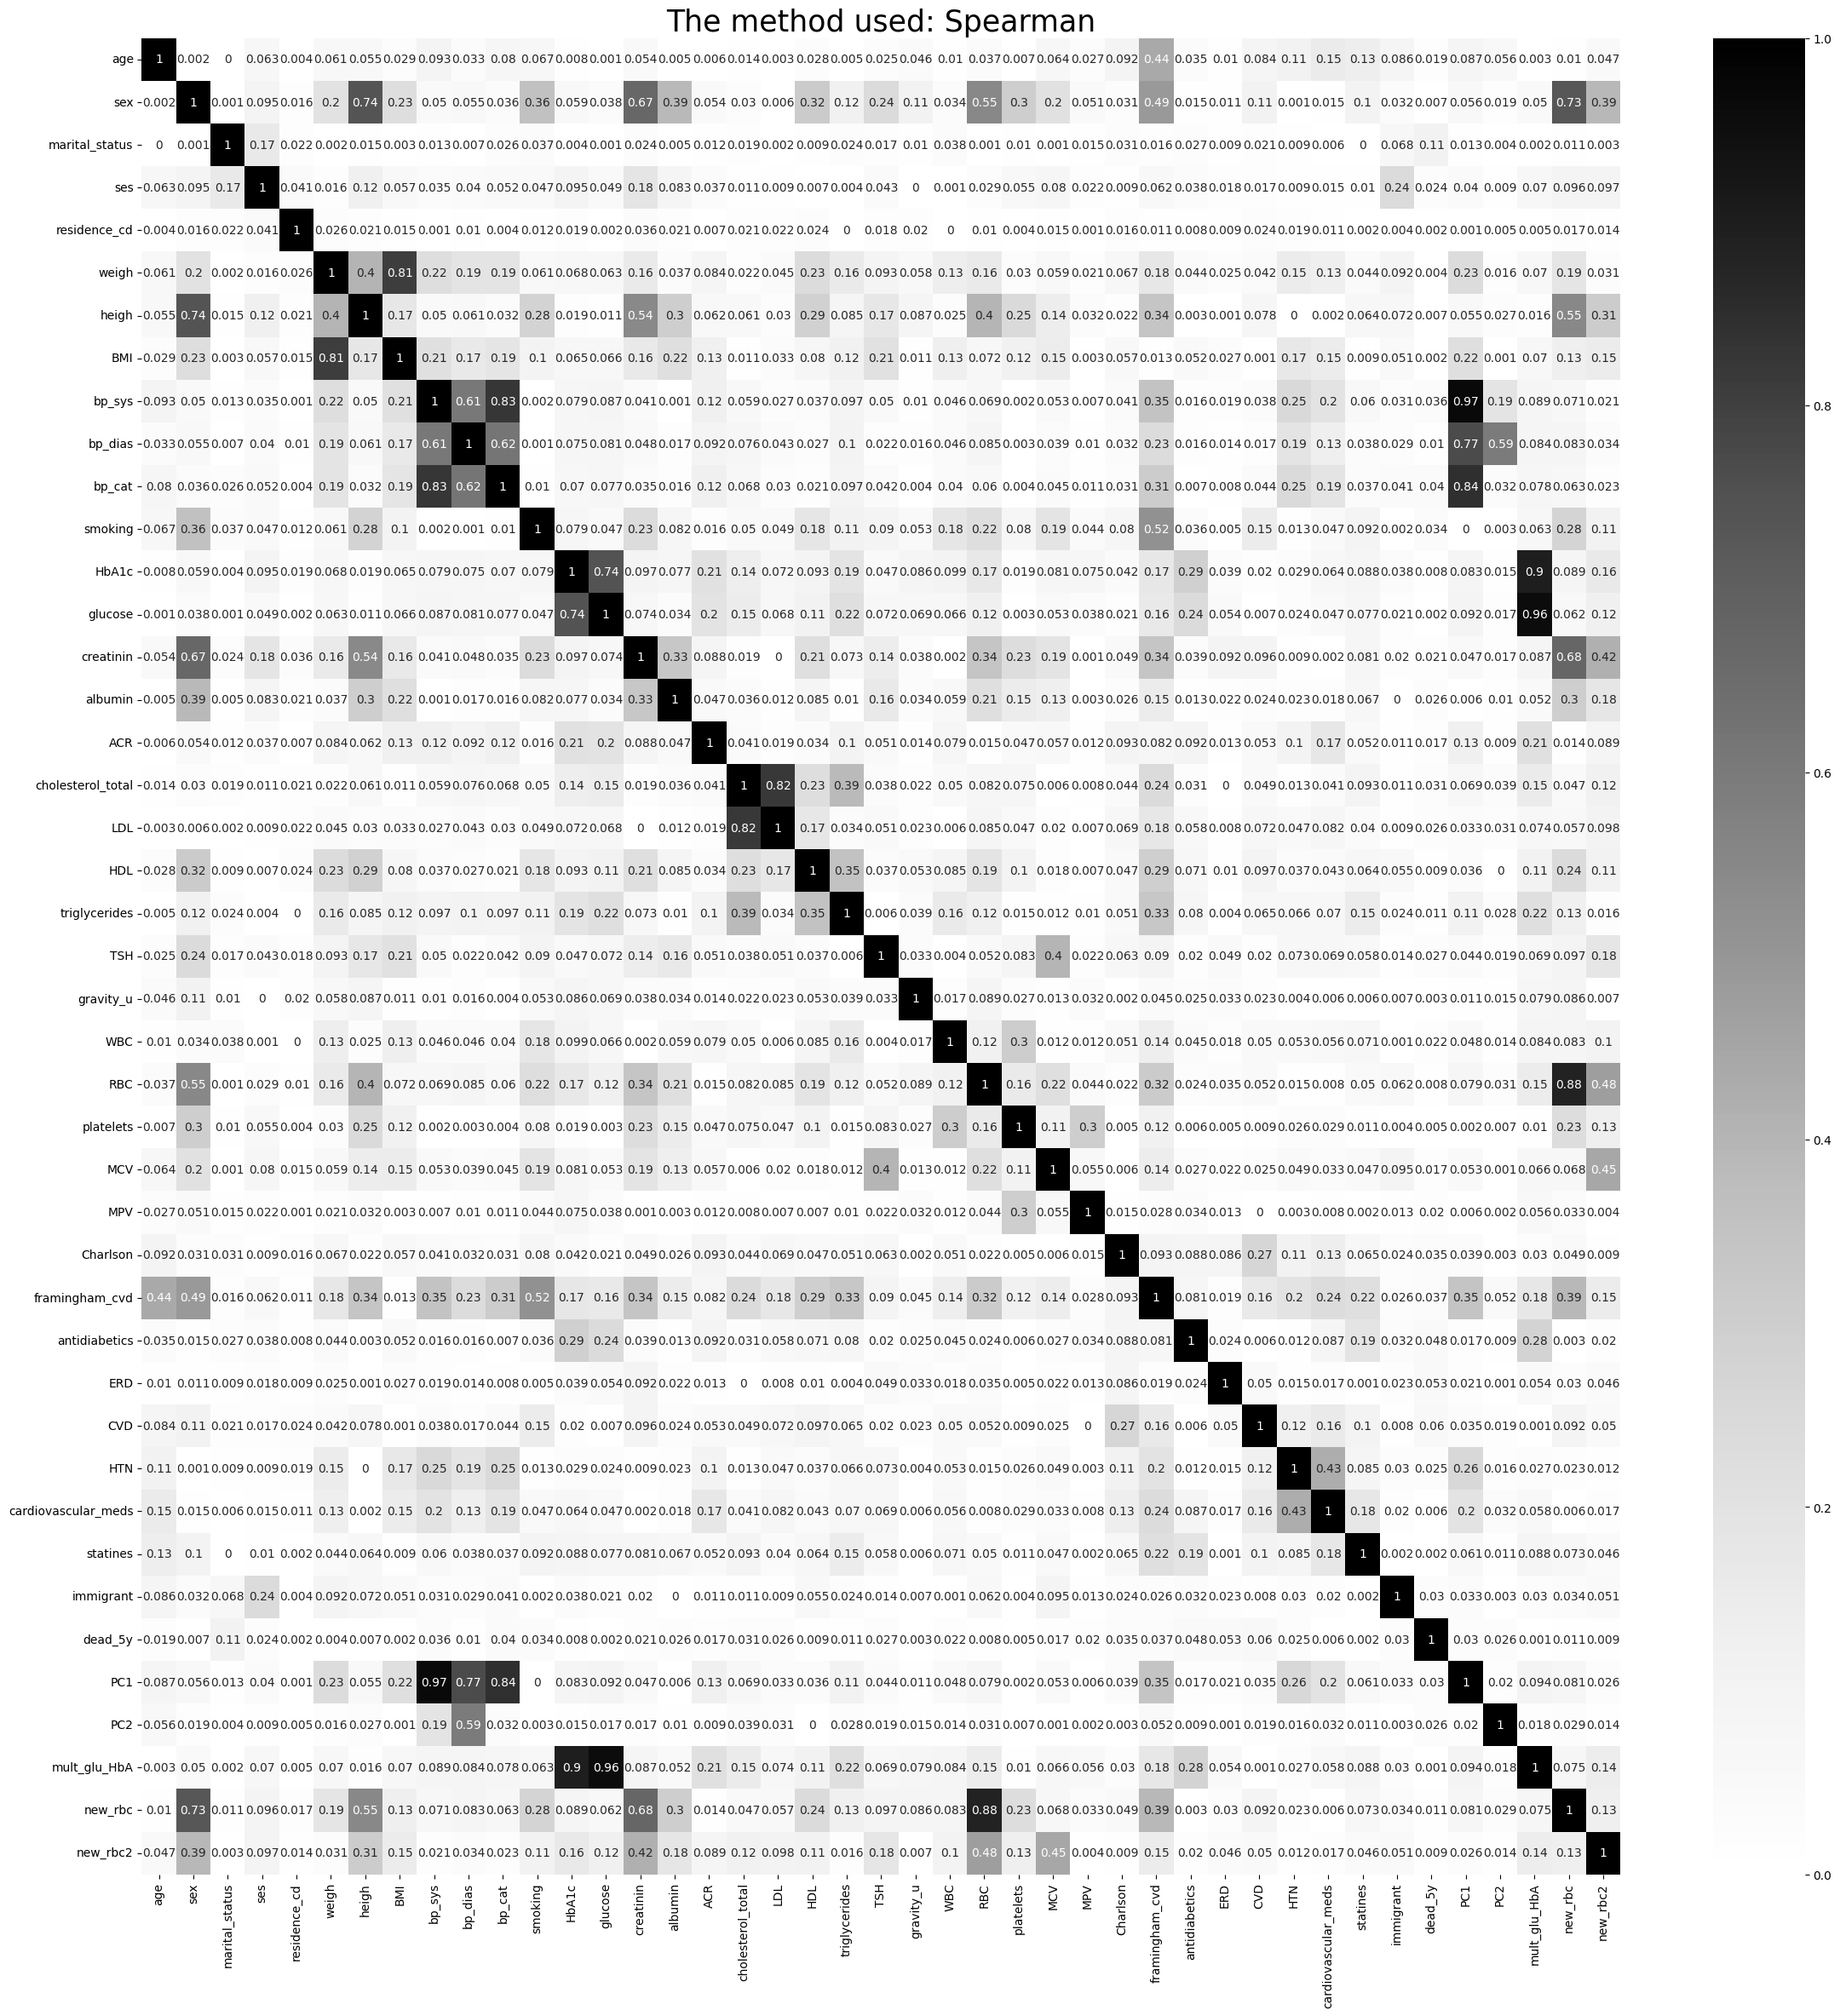

(None, None)

In [43]:
plot_correlation(), plot_correlation('spearman')

In [44]:
train_df = train_df.drop(['bp_sys', 'bp_dias', 'bp_cat', 'weigh', 'heigh',
'cholesterol_total', 'HbA1c', 'glucose', 'sex', 'RBC', 'creatinin'], axis=1)

In [45]:
train_df['framingham_cvd'].loc[(train_df['framingham_cvd'] > 0.13) &(train_df['smoking'] == 1) & (train_df['dead_5y'] == 1)].count()

30

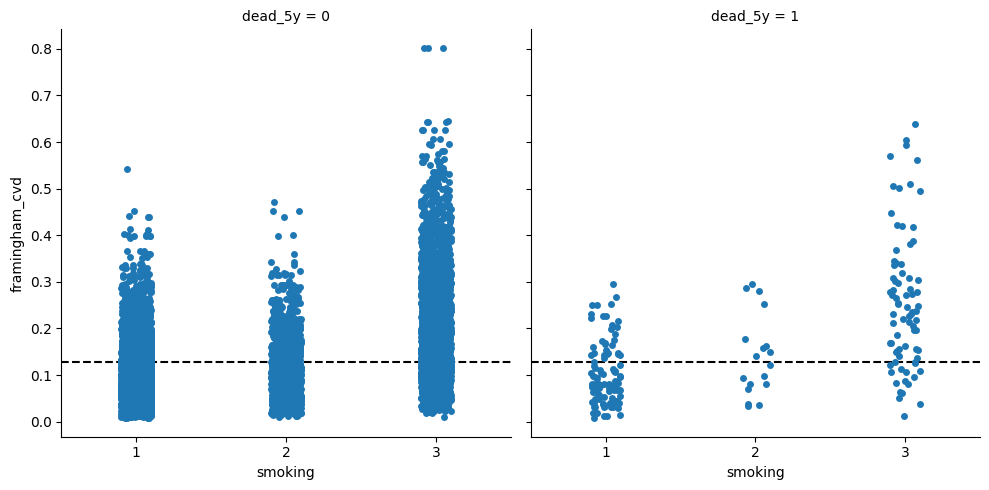

In [46]:
data = train_df[['framingham_cvd', 'smoking','dead_5y']]
f = sns.catplot(data=data, x='smoking', y='framingham_cvd', col='dead_5y')
f.axes[0][0].axhline(y=train_df['framingham_cvd'].mean(), color='black', ls='--')
f.axes[0][1].axhline(y=train_df['framingham_cvd'].mean(), color='black', ls='--')

In [47]:
train_df = train_df.drop(['framingham_cvd'], axis=1)
train_df.shape

(12438, 31)

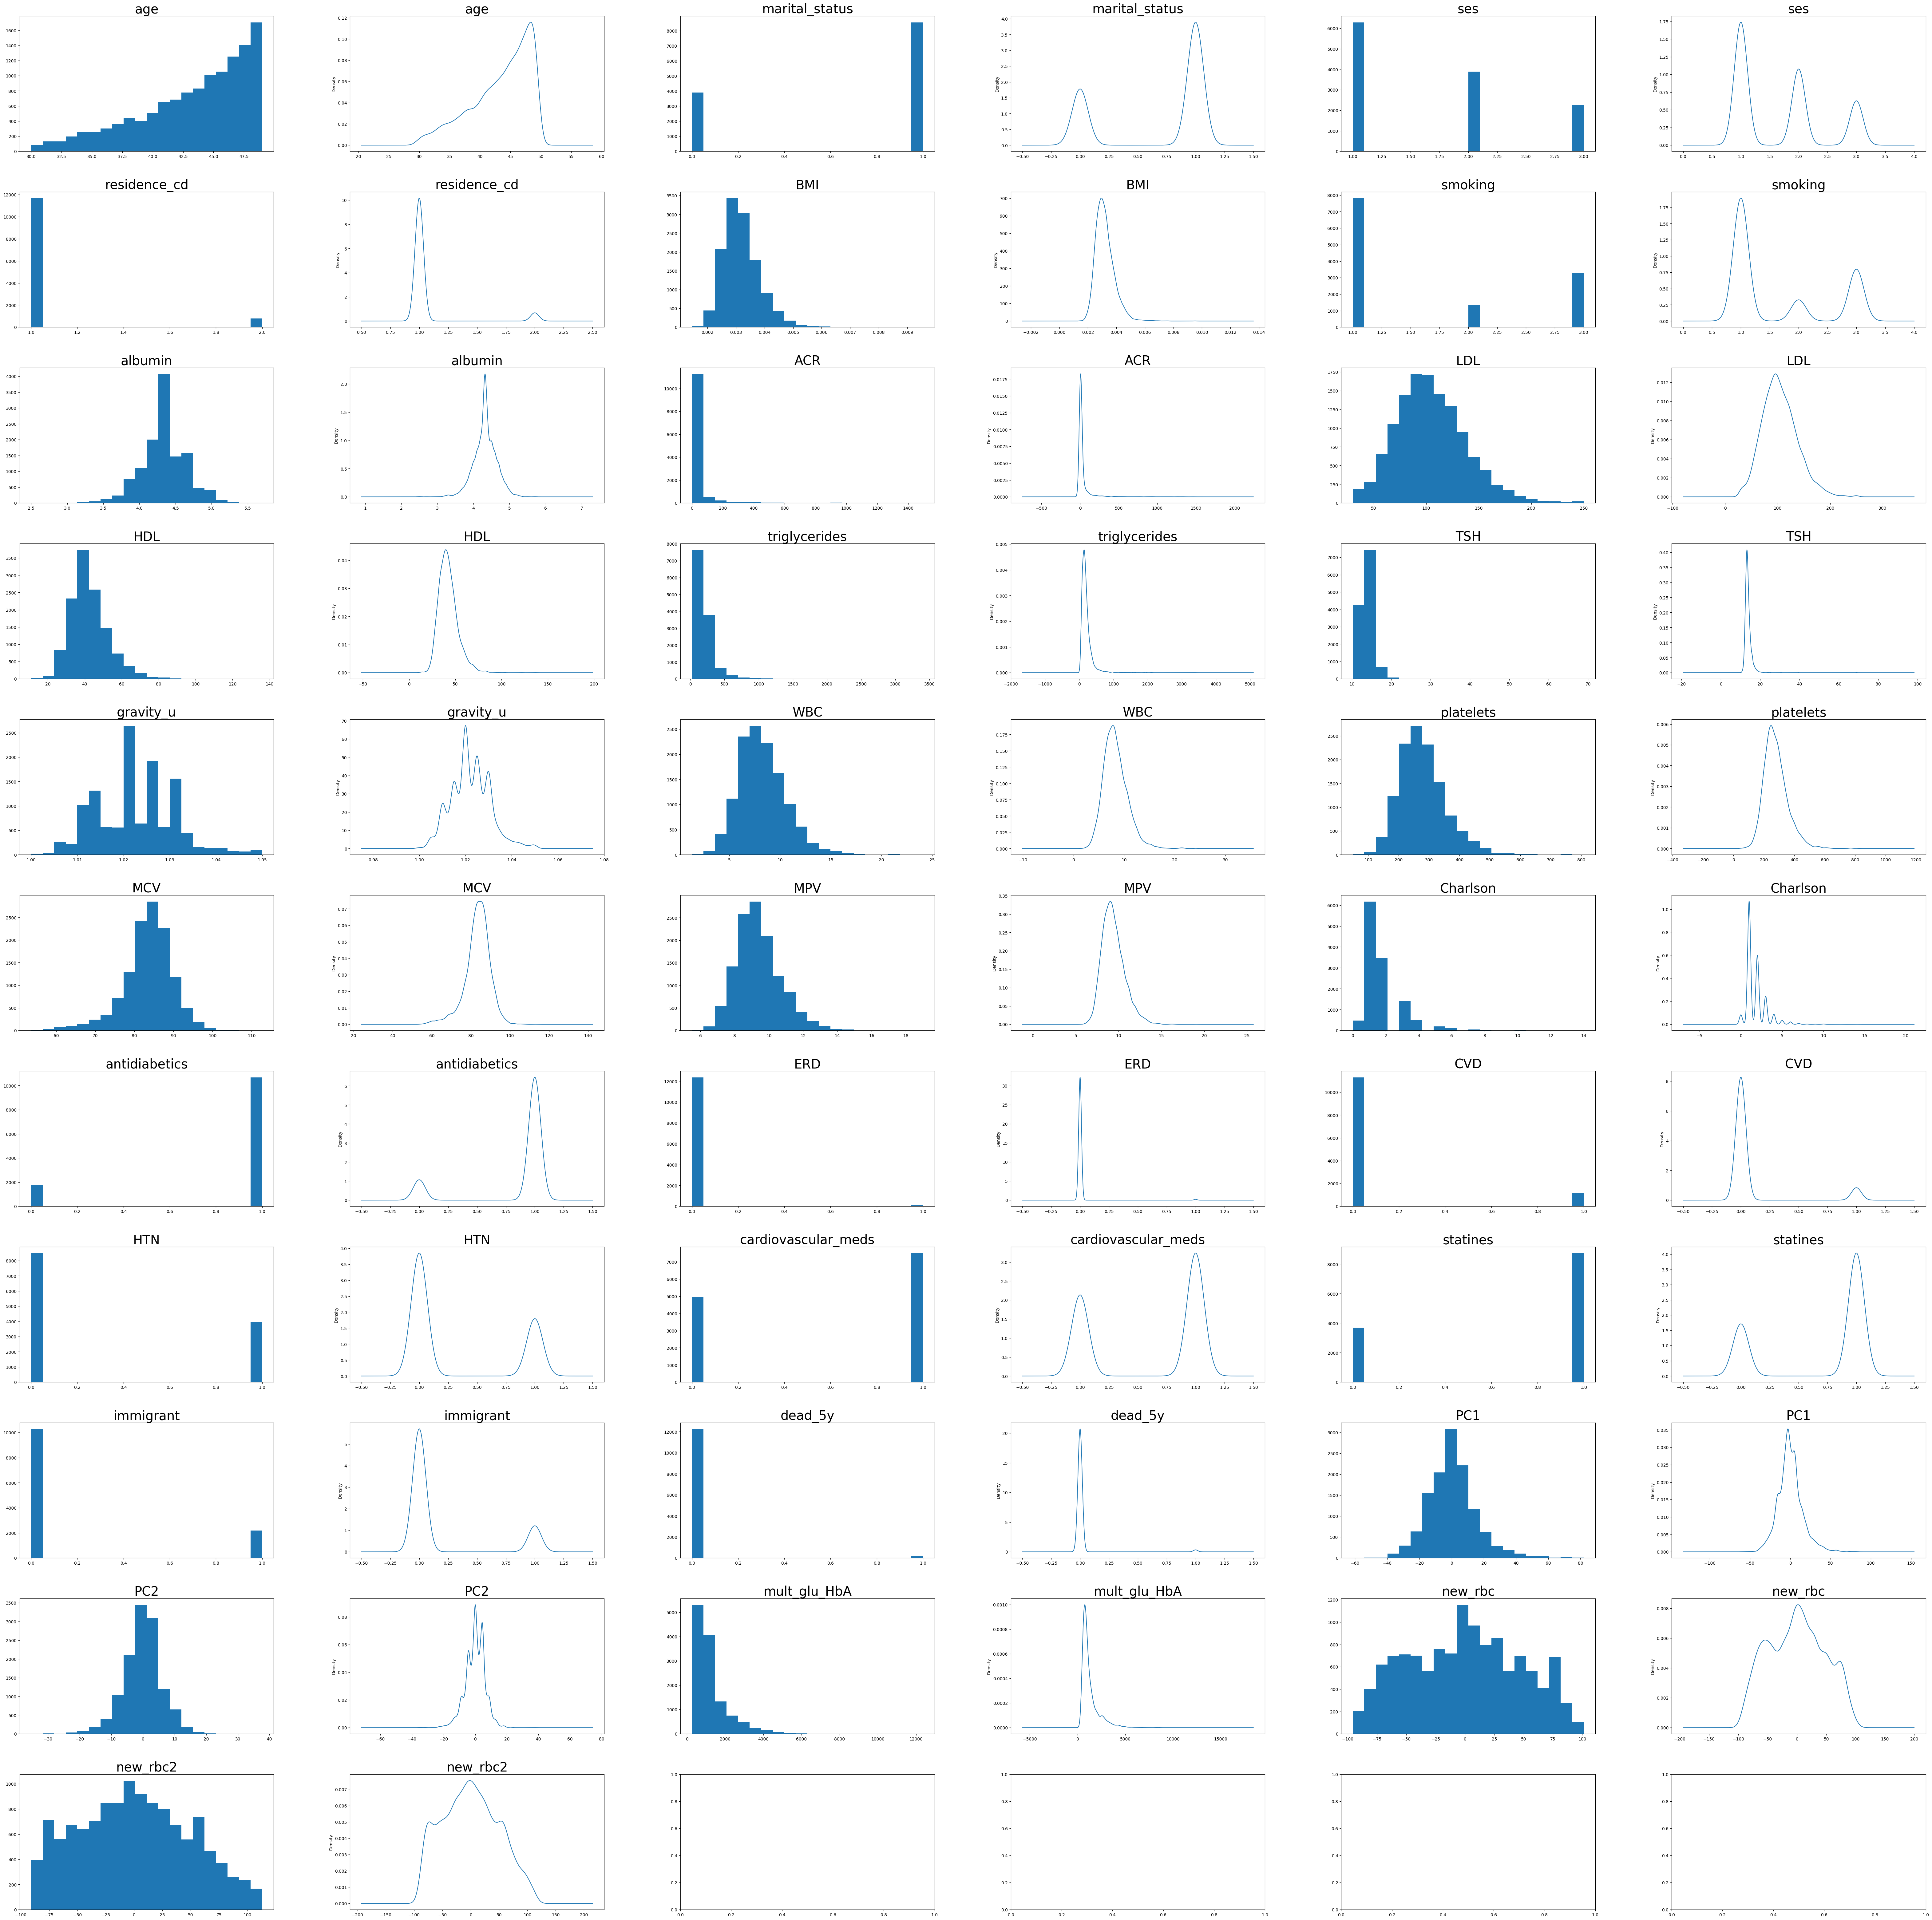

In [48]:
fig, axes = plt.subplots(nrows=11, ncols=6) 
fig.set_figheight(80)
fig.set_figwidth(80)
i = 0
j = 0
for col in train_df.columns:
  train_df.hist(column=col, bins=20, grid=False, ax=axes[i, j%3*2])
  train_df[col].plot.kde(ax=axes[i, j%3*2+1])
  title = col
  fontSize = 30
  colour = 'black'
  axes[i, j%3*2].set_title(title, fontsize=fontSize, color=colour)
  axes[i, j%3*2+1].set_title(title, fontsize=fontSize, color=colour)
  j += 1 
  if j % 3 == 0:
     i += 1